In [15]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from tqdm.notebook import tqdm
import PIL
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data
import random
np.random.seed(0)
from timm.models import vit_base_patch16_224
from ipywidgets import FloatProgress
# Set seed for PyTorch
seed = 42
random.seed(seed)
np.random.seed(seed)
from torchvision import datasets, transforms
from dataset.RSNA_dataset import RSNADataset

# Set seed for PyTorch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [16]:
dataset = 'RSNA'
norm = 0.5
BATCH_SIZE = 128
task = 'binary-class'
device = 'cuda'
csv = '/home/santosh.sanjeev/model-soups/my_soups/rsna_18/csv/final_dataset_wo_not_normal_cases.csv'
data_dir = '/home/santosh.sanjeev/model-soups/my_soups/rsna_18/'

In [17]:
data_flag = 'pneumoniamnist'
download = True
info = INFO[data_flag]
# task = info['task']            
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
if norm!=0.5:
    print('USING IMAGENET NORM')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)
else:
    print('NOT USING IMAGENET NORM')
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    normalize = transforms.Normalize(mean=mean, std=std)

# preprocessing
data_transform = transforms.Compose([
    # transforms.RandomRotation(degrees=15, fill=(0,0,0)),  # Random rotation with 15 degrees
    # transforms.RandomVerticalFlip(p=0.3),  # Random vertical flip with 50% probability
    # transforms.RandomHorizontalFlip(p=0.3),  # Random horizontal flip with 50% probability
    transforms.Resize((224, 224), interpolation=PIL.Image.NEAREST),
    transforms.ToTensor(),
    normalize
])

if dataset == 'cifar10':
    print('CIFARRRRRRRRRRRRRRRRR')
    # # Define transformations to be applied to the images
    # transform = transforms.Compose([
    #     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    #     transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    #     transforms.ToTensor(),
    #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
    # ])

    # Load CIFAR-10 dataset
    train_dataset = datasets.CIFAR10(root='./data', train=True, transform=data_transform, download=True)
    test_dataset = datasets.CIFAR10(root='./data', train=False, transform=data_transform, download=True)

    # Split the training dataset into training and validation sets
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

elif dataset == 'RSNA':
    train_dataset = RSNADataset(csv_file = csv, data_folder = data_dir, split='train', transform=data_transform)
    val_dataset = RSNADataset(csv_file = csv, data_folder = data_dir, split='val', transform=data_transform)
    test_dataset = RSNADataset(csv_file = csv, data_folder = data_dir, split='test', transform=data_transform)

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
else:
    train_dataset = DataClass(split='train', transform=data_transform, download=download, as_rgb=True)
    test_dataset = DataClass(split='test', transform=data_transform, download=download,  as_rgb=True)
    val_dataset = DataClass(split='val', transform=data_transform, download=download,  as_rgb=True)

    train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(dataset)
print(len(train_dataset))
print("===================")
print(len(val_dataset))
print("===================")
print(len(test_dataset))

NOT USING IMAGENET NORM
RSNA
11911
1469
1483


In [18]:
import torch.nn as nn
from sklearn.metrics import f1_score, roc_auc_score

def evaluate_model(model, test_loader):
    print(task)
    test_correct = 0
    test_total = 0
    test_predictions = []
    test_targets = []
    test_f1_predictions = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            m = nn.Softmax(dim=1)            
            predicted = m(outputs)
            # _, predicted = torch.max(outputs.data, 1)
            targets = targets.squeeze().long()
            test_total += targets.size(0)
            _,t = torch.max(outputs.data, 1)
            test_correct += (t == targets).sum().item()
#             print(t)
            if task == 'binary-class':
                predicted = predicted[:,-1]

            test_predictions.extend(predicted.cpu().numpy())
            test_f1_predictions.extend(t.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())
            # print(test_correct, test_total)
        test_accuracy = 100 * test_correct / test_total
        if task !='binary-class':
            test_f1 = f1_score(test_targets, test_f1_predictions, average = 'macro')
            test_auc = roc_auc_score(test_targets, test_predictions, average = 'macro', multi_class = 'ovr')
        else:
            test_f1 = f1_score(test_targets, test_f1_predictions)
            test_auc = roc_auc_score(test_targets, test_predictions)
        # Print or log validation metrics
        print(f"Test Accuracy: {test_accuracy:.2f}%, F1-Score: {test_f1:.4f}, AUC: {test_auc:.4f}")
        return test_accuracy, test_f1, test_auc


In [19]:
from models.model import ImageNetModel, CLIPModel
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_pretrained_model(path, load_model = 'vit_b_16'):
    
    # model =  getattr(models, load_model)(pretrained=True)
    # model = torch.nn.Sequential(*list(model.children())[:-1])
    # full_model = ImageNetModel(model, num_classes=n_classes)
    
    full_model = vit_base_patch16_224(pretrained=True)
    full_model.head = nn.Linear(full_model.head.in_features, 2)

    print(full_model)
    checkpoint = torch.load(path)  # Provide the path to your weights file
    full_model.load_state_dict(checkpoint['model_state_dict'])

    
    return full_model

In [20]:
models_folder = '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/'
model_paths = [os.path.join(models_folder, filename) for filename in os.listdir(models_folder) if filename.endswith('.pth') and not filename.endswith('.csv')]
model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]
print(model_paths)
print(model_names)

['/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_11.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_3.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_4.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_10.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_5.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_2.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_1.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_6.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_8.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_13.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/

In [21]:
# model_paths.remove('/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_13.pth')
# model_names.remove('model_13')

In [22]:
# print(model_paths, model_names)

In [23]:
state_dicts = []
for model_path, model_name in zip(model_paths, model_names):
    checkpoint = torch.load(model_path)
    state_dicts.append(checkpoint['model_state_dict'])

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# models_folder = '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/cifar10_v3/'
# model_paths = [os.path.join(models_folder, filename) for filename in os.listdir(models_folder) if filename.endswith('.pth') and not filename.endswith('.csv')]
# model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]
results = []
# results_df = pd.DataFrame(columns=['Model Name', 'Test Accuracy', 'Test F1', 'Test AUC'])

for model_path, model_name in zip(model_paths, model_names):
    model = load_pretrained_model(model_path)
    test_accuracy, test_f1, test_auc = evaluate_model(model, test_loader)
    results.append({'Model Name': model_name,
                                    'Test Accuracy': test_accuracy,
                                    'Test F1': test_f1,
                                    'Test AUC': test_auc})
results_df = pd.DataFrame(results)
results_df


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 86.72%, F1-Score: 0.8420, AUC: 0.9470
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 92.04%, F1-Score: 0.8969, AUC: 0.9720
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 94.40%, F1-Score: 0.9273, AUC: 0.9813
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 91.23%, F1-Score: 0.8852, AUC: 0.9671
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 90.69%, F1-Score: 0.8832, AUC: 0.9718
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 93.39%, F1-Score: 0.9169, AUC: 0.9826
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 92.11%, F1-Score: 0.8945, AUC: 0.9753
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 89.68%, F1-Score: 0.8789, AUC: 0.9770
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 91.57%, F1-Score: 0.8901, AUC: 0.9678
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 94.47%, F1-Score: 0.9291, AUC: 0.9837
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 92.52%, F1-Score: 0.9034, AUC: 0.9753
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 92.78%, F1-Score: 0.9088, AUC: 0.9768
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 92.52%, F1-Score: 0.9042, AUC: 0.9749
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dr

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 91.44%, F1-Score: 0.8881, AUC: 0.9677


,Model Name,Test Accuracy,Test F1,Test AUC
0,model_11,86.716116,0.842021,0.947043
1,model_3,92.043156,0.896853,0.972026
2,model_4,94.403237,0.927257,0.981296
3,model_10,91.233985,0.885159,0.967141
4,model_5,90.694538,0.883249,0.971828
5,model_2,93.391773,0.916949,0.982588
6,model_1,92.110587,0.894500,0.975270
7,model_6,89.683075,0.878860,0.976976
8,model_8,91.571140,0.890062,0.967763
9,model_13,94.470668,0.929066,0.983714


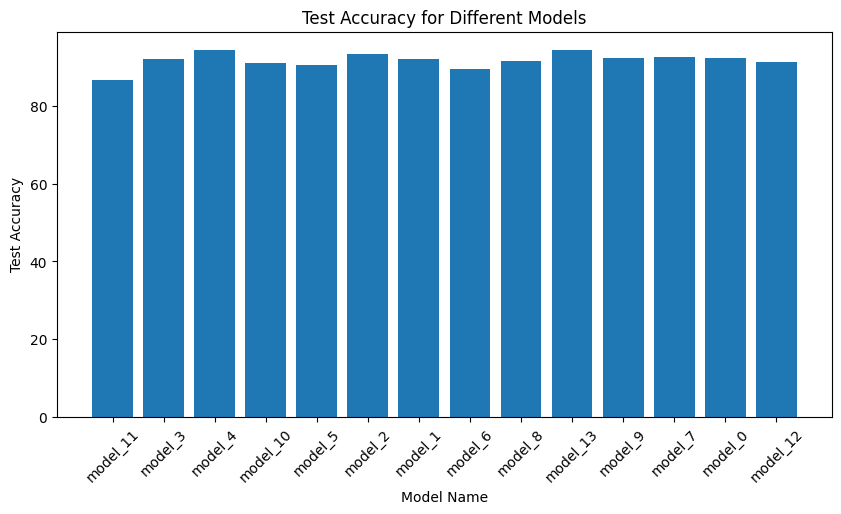

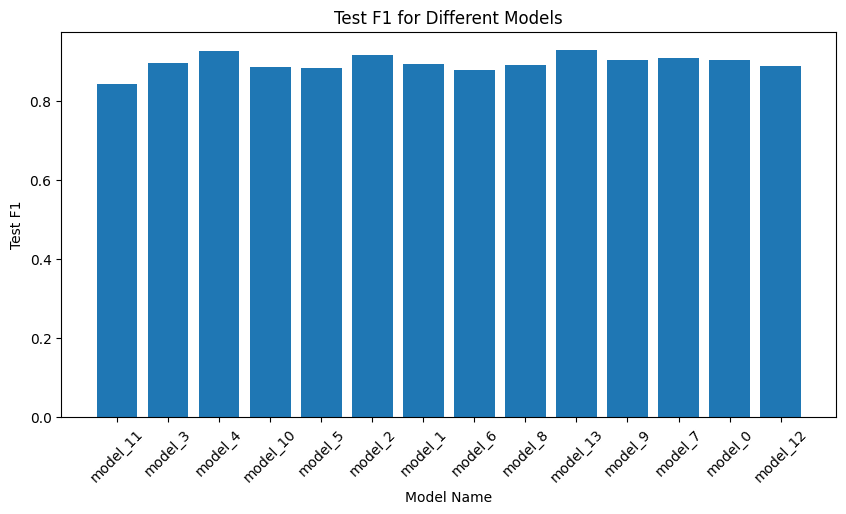

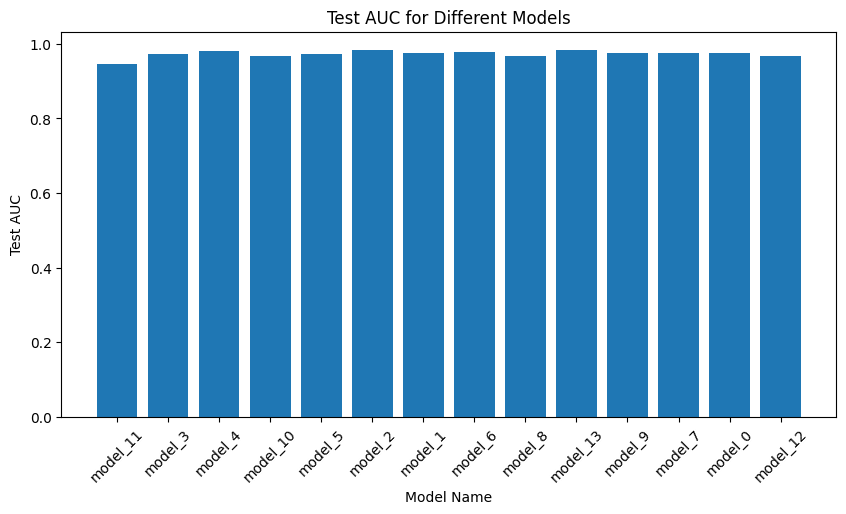

In [25]:
# Plot the bar graph
metrics = ['Test Accuracy', 'Test F1', 'Test AUC']
for metric in metrics:
    plt.figure(figsize=(10, 5))
    plt.bar(results_df['Model Name'], results_df[metric])
    plt.xlabel('Model Name')
    plt.ylabel(metric)
    plt.title(f'{metric} for Different Models')
    plt.xticks(rotation=45)
    plt.show()

In [26]:
results_df

,Model Name,Test Accuracy,Test F1,Test AUC
0,model_11,86.716116,0.842021,0.947043
1,model_3,92.043156,0.896853,0.972026
2,model_4,94.403237,0.927257,0.981296
3,model_10,91.233985,0.885159,0.967141
4,model_5,90.694538,0.883249,0.971828
5,model_2,93.391773,0.916949,0.982588
6,model_1,92.110587,0.894500,0.975270
7,model_6,89.683075,0.878860,0.976976
8,model_8,91.571140,0.890062,0.967763
9,model_13,94.470668,0.929066,0.983714


In [27]:
def get_model(state_dicts, alphal):
    sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
    full_model = vit_base_patch16_224(pretrained=True)
    full_model.head = nn.Linear(full_model.head.in_features, 2)
    for i in range(1,len(state_dicts)):
        for k in state_dicts[i].keys():
            sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
    full_model.load_state_dict(sd)
    full_model = full_model.to(device)
    return full_model

In [28]:
# model_paths = ['/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/model_23.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/model_22.pth']#, '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/model_1.pth']

# state_dicts = []
# for model_path, model_name in zip(model_paths, model_names):
#     checkpoint = torch.load(model_path)
#     state_dicts.append(checkpoint['model_state_dict'])

In [29]:
device = 'cuda'

alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
print(len(state_dicts))
model1 = get_model(state_dicts, alphal)
test_accuracy, test_f1, test_auc = evaluate_model(model1, test_loader)
results = []
results.append({'Model Name': model_name,'Test Accuracy': test_accuracy,'Test F1': test_f1, 'Test AUC': test_auc})

14
binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 78.76%, F1-Score: 0.7031, AUC: 0.8603


In [30]:
def average_models(model_paths):
    models = [load_pretrained_model(path) for path in model_paths]
    state_dicts = [model.state_dict() for model in models]
    averaged_state_dict = {}
    
    for key in state_dicts[0].keys():
        param_sum = sum(state_dict[key] for state_dict in state_dicts)
        averaged_state_dict[key] = param_sum / len(models)
    
    averaged_model = load_pretrained_model(model_paths[0])
    averaged_model.load_state_dict(averaged_state_dict)
    
    return averaged_model



In [31]:
models_path = ['/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_4.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_13.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_2.pth']
averaged_model = average_models(models_path)
test_accuracy, test_f1, test_auc = evaluate_model(averaged_model, test_loader)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 91.50%, F1-Score: 0.8984, AUC: 0.9816


In [32]:
models_path = ['/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_4.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_13.pth', '/home/santosh.sanjeev/model-soups/my_soups/checkpoints/grid_models/rsna_VIT_v1/model_2.pth']

state_dicts = []
for model_path, model_name in zip(models_path, model_names):
    checkpoint = torch.load(model_path)
    state_dicts.append(checkpoint['model_state_dict'])

In [33]:
device = 'cuda'

alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
print(len(state_dicts))
model1 = get_model(state_dicts, alphal)
test_accuracy, test_f1, test_auc = evaluate_model(model1, test_loader)
results = []
results.append({'Model Name': model_name,'Test Accuracy': test_accuracy,'Test F1': test_f1, 'Test AUC': test_auc})

3
binary-class


  0%|          | 0/12 [00:00<?, ?it/s]

Test Accuracy: 91.50%, F1-Score: 0.8984, AUC: 0.9816
